# Relatório do projeto - Mineração de Dados

## Matheus Fernandes, Pedro Faustini

## 1. Introdução

Este trabalho estuda técnicas de mineração de dados para classificar áudio. Em específico, o universo a ser classificado consiste em dez caracteres: 6, 7, a, b, c, d, h, m, n, x. Cada arquivo de áudio, chamado de _captcha_, contém 4 caracteres, podendo haver repetição. A classificação de um _captcha_ é considerada sucesso somente se **todos** os seus quatro caracteres são corretamente identificados.

### Ferramentas necessárias para a reprodução:

Para este trabalho foram utilizadas as ferramentas mencionadas abaixo.

#### Aambientes e bibliotecas
- FFMPEG
- Anaconda (Python>=3.5) 
- numpy>=1.13.3
- pandas>=0.20.3
- scikit-learn>=0.19.1
- scipy==1.1.0 
- librosa>=0.6.1
- matplotlib>=1.5.3
- ipython>=6.2.1
- Sox (`conda install -c conda-forge sox`)

#### Pastas
- É **assumido** que no diretório em que se encontra este documento haja uma pasta chamada *fase\_II*. Dentro desta pasta deve haver duas pastas: *base\_treinamento\_II* e *base\_validacao\_II*, cada uma uma com os captchas de áudio. Também é assumido que a base de teste, a qual não tivemos acesso durante o desenvolvimento deste trabalho, esteja dentro da pasta *fase\_II* e se chame *base\_teste\_II*.


Numpy e Pandas manipulam vetores de uma forma mais otimizada e rica em informação em relação à classe _list_ da biblioteca padrão do Python. Scikit-learn implementa diversos algoritmos de mineração de dados, bem como técnicas de transformação e pré-processamento. Scipy é uma biblioteca usada para computação científica. Matplotlib fornece funções para plotar imagens e gráficos. Por fim, librosa é uma biblioteca para manipulação de áudio. Também fornecemos junto com os arquivos a biblioteca `pysndfx`, que nada mais é do que um *wrapper* para o Sox. A biblioteca está disponível no [Github](https://github.com/carlthome/python-audio-effects).

In [1]:
from IPython.display import display

## 2. Análise exploratória

A primeira tarefa é criar a estrutura de pastas necessárias para segmentar os _captchas_. Como cada _captcha_ contém quatro caracteres, a ideia é gerar quatro arquivos `.wav`, um para cada caractere.

In [2]:
from main import create_folder_structure
create_folder_structure()

### 2.1 Segmentação

A segmentação segue os passos:

- O áudio é normalizado (tornando o maior pico = 1) e os silêncios ao início e ao fim são removidos;
- Um _limiter_ é aplicado, com o parâmetro de 20dB. Isso significa que qualquer sinal com intensidade maior que este limite são diminuídos até 20dB. Isso é feito para tentar reduzir a diferença entre picos mais altos e mais baixos, pois nem todas as letras são gravadas com a mesma intensidade;
- Frequências acima de 2500Hz e abaixo de 100Hz são descartadas, pois são frequências com pouca informação vocal;
- Então, um equalizador é aplicado na faixa de 300Hz, intensificando essas frequências por 15dB. Na prática, isso causa um *boost* nas regiões onde há grande informação vocal, potencialmente até distorcendo-as, e deixando a diferença entre voz e fundo muito mais clara;
- Samples com intensidade menor que 0.5 são zerados, em uma tentativa de remover ruído de gravação. Idealmente, regiões silenciosas (sem voz) seriam zeradas;
- A função `find_peaks`, da biblioteca `scipy.signal` é usada para encontrar os picos do áudio. Essa função retorna todos os máximos e mínimos locais de um sinal. Mesmo passando parâmetros de altura mínima (de forma a apenas encontrar máximos) e distância mínima de 1s entre picos, por vezes a função encontra mais do que 4 picos, chamados daqui em diante de pontos;
- A intenção é que cada ponto represente um caractere. São escolhidos os pares de pontos mais próximos um do outro, e ambos são removidos e substituídos pela sua média. Isso é feito até que restem apenas 4 pontos. Teoricamente, ao fazer isso estamos pegando os caracteres com mais de um pico e colapsando suas posições até restar apenas um ponto, próximo ao seu centro;
- A partir de cada ponto encontrado, é extraída do áudio original uma região de 1s para cada lado, totalizando no máximo 2s de áudio. O ruído de fundo (silêncio) de cada lado e removido, isolando apenas a fala, e, como essa operação normalmente remove o começo e final do caractere, 0.25s são adicionados de volta de cada lado;
- Os áudios encontrados são exportados, assumindo que foram encontrados na ordem em que estão presentes no nome do arquivo.


Na imagem abaixo, desenhamos as ondas de um exemplo da base de treinamento.

A onda verde representa o áudio original; a onda azul mostra o áudio após feito o processamento. Pode-se notar que os picos estão bem mais visíveis, e as regiões de ruído de fundo tornaram-se silêncio; dessa forma, temos um áudio próximo de "binarizado", onde 1 é fala, e 0 é silêncio.

Os riscos em vermelho são os quatro pontos encontrados.

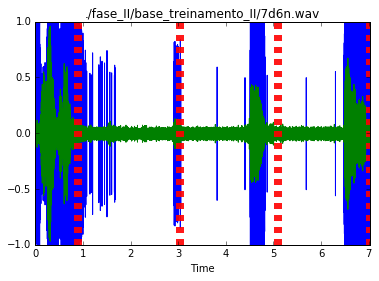

In [3]:
import preprocessor as trim

trim.trim('./fase_II/base_treinamento_II/7d6n.wav', '', True) #desenha o grafico

### 2.2 Análise preliminar de classificadores

Em um primeiro momento, é necessário criar a estrutura de pastas para que os algoritmos de mineração de dados atuem. É **assumido** que haja, no atual diretório, uma pasta chamada *fase\_II/base\_treinamento\_II*, uma pasta chamada *fase\_II/base_validacao\_II* e outra chamada *fase\_II/base_teste\_II*. Dentro dessas pastas, há uma pasta para cada _captcha_ contendo um arquivo .wav, cujo nome são os quatro caracteres que compõem o _captcha_ na ordem em que aparecem.

Desta forma, a estrutura de pastas necessária para a classificação é montada. Os arquivos segmentados ficam nas pastas *output\_training*, *output\_validation* e *output\_test*. Dentro de cada pasta há um arquivo .wav para cada caractere identificado na segmentação. O nome de cada arquivo é *ordem\-caractere.wav*. Por exemplo, se o terceiro caractere de um dado _captcha_ for a letra "d", o nome do arquivo correspondente a ele será *3-d.wav*.

In [4]:
from model import train, individual_classifiers_results, test, get_final_model, final_test

In [5]:
from display_results import resultados_acuracia, resultados_caracteres

A seguir é necessário extrair atributos da base de dados.

A função `get_spectrum` extrai a intensidade média dentro de cada um dos [espectros de áudio](https://www.teachmeaudio.com/mixing/techniques/audio-spectrum/). Por exemplo, os espectros mais agudos poderiam ajudar um classificador a separar caracteres sibilantes (com sons de "S", como x e 7) de caracteres não sibilantes (como m e h).

Com o auxílio da biblioteca *librosa*, extraímos o [MFCC](https://www.maxwell.vrac.puc-rio.br/23090/23090_4.PDF) (Mel-Frequency Cepstral Coefficients) das ondas sonoras. Para cada áudio, o MFCC retornado é uma matriz, onde cada linha possui um vetor numérico. O MFCC procura imitar as características que seres humanos percebem pelo ouvido. Para não lidar com um número absurdamente grande de atributos, usamos somente a mediana e o desvio padrão de cada vetor, que teve todos os valores tornados positivos. Isso foi feito porque os vetores do MFCC continham valores negativos e positivos (ondas), e assim a mediana tenderia a ser sempre próxima de zero.

Além disso, também com o auxílio da *librosa*, contamos quantas vezes o áudio corta o zero no eixo y, dividido pelo tamanho do áudio, a fim de ter um valor normalizado.

A função `extract_features`, chama as funções acima citadas para criar o vetor de *features*. 

O treinamento é feito sobre toda a base de treino, e os dados são normalizados de forma a terem média 0 e desvio 1. Isso é importante principalmente para algoritmos baseados em distância, de forma que atributos com valores maiores não dominem a classificação em detrimento de outros cujos valores tendem a ser mais próximos de zero.

Primeiro avaliamos o desempenho individual de quatro algoritmos: 1NN, 3NN, SVM e LDA. Os resultados de sua acurácia, tanto para *captchas* como para caracteres, estão nas tabelas abaixo.

In [6]:
X_train, y_train, std_scale = train()

In [7]:
captchas_svm, caracteres_svm, captchas_1nn, caracteres_1nn, captchas_3nn, caracteres_3nn, captchas_lda, caracteres_lda, elementos, corretos_svm,corretos_1nn, errados_svm,errados_1nn, corretos_lda,corretos_3nn, errados_lda,errados_3nn = individual_classifiers_results(X_train, y_train, std_scale)

In [8]:
display(resultados_caracteres("Caracteres individuais SVM", corretos_svm, errados_svm, elementos))

### RESULTADOS Caracteres individuais SVM
|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
| 6 | 42/70 (60.00) | 28/70 (40.00)
| 7 | 51/63 (80.95) | 12/63 (19.05)
| a | 46/64 (71.88) | 18/64 (28.12)
| b | 28/52 (53.85) | 24/52 (46.15)
| c | 28/66 (42.42) | 38/66 (57.58)
| d | 8/54 (14.81) | 46/54 (85.19)
| h | 50/55 (90.91) | 5/55 (9.09)
| m | 31/56 (55.36) | 25/56 (44.64)
| n | 18/45 (40.00) | 27/45 (60.00)
| x | 50/67 (74.63) | 17/67 (25.37)

In [9]:
display(resultados_acuracia("GERAL SVM", [("Acuracia SVM (captcha)", "{0:.2f}".format(captchas_svm)), ("Acuracia (caracteres)", "{0:.2f}".format(caracteres_svm)) ]))

### RESULTADOS GERAL SVM
| Métrica | Taxa  |
|:-:|:-:|
|Acuracia SVM (captcha)| 15.44%|
|Acuracia (caracteres)| 59.46%|

In [10]:
display(resultados_caracteres("Caracteres individuais 1NN", corretos_1nn, errados_1nn, elementos))

### RESULTADOS Caracteres individuais 1NN
|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
| 6 | 39/70 (55.71) | 31/70 (44.29)
| 7 | 41/63 (65.08) | 22/63 (34.92)
| a | 39/64 (60.94) | 25/64 (39.06)
| b | 19/52 (36.54) | 33/52 (63.46)
| c | 29/66 (43.94) | 37/66 (56.06)
| d | 20/54 (37.04) | 34/54 (62.96)
| h | 45/55 (81.82) | 10/55 (18.18)
| m | 29/56 (51.79) | 27/56 (48.21)
| n | 24/45 (53.33) | 21/45 (46.67)
| x | 35/67 (52.24) | 32/67 (47.76)

In [11]:
display(resultados_acuracia("GERAL 1NN", [("Acuracia 1NN (captcha)", "{0:.2f}".format(captchas_1nn)), ("Acuracia (caracteres)", "{0:.2f}".format(caracteres_1nn)) ]))

### RESULTADOS GERAL 1NN
| Métrica | Taxa  |
|:-:|:-:|
|Acuracia 1NN (captcha)| 8.72%|
|Acuracia (caracteres)| 54.05%|

In [12]:
display(resultados_caracteres("Caracteres individuais 3NN", corretos_3nn, errados_3nn, elementos))

### RESULTADOS Caracteres individuais 3NN
|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
| 6 | 43/70 (61.43) | 27/70 (38.57)
| 7 | 41/63 (65.08) | 22/63 (34.92)
| a | 35/64 (54.69) | 29/64 (45.31)
| b | 28/52 (53.85) | 24/52 (46.15)
| c | 23/66 (34.85) | 43/66 (65.15)
| d | 13/54 (24.07) | 41/54 (75.93)
| h | 44/55 (80.00) | 11/55 (20.00)
| m | 21/56 (37.50) | 35/56 (62.50)
| n | 16/45 (35.56) | 29/45 (64.44)
| x | 26/67 (38.81) | 41/67 (61.19)

In [13]:
display(resultados_acuracia("GERAL 3NN", [("Acuracia 3NN (captcha)", "{0:.2f}".format(captchas_3nn)), ("Acuracia (caracteres)", "{0:.2f}".format(caracteres_3nn)) ]))

### RESULTADOS GERAL 3NN
| Métrica | Taxa  |
|:-:|:-:|
|Acuracia 3NN (captcha)| 3.36%|
|Acuracia (caracteres)| 48.99%|

In [14]:
display(resultados_caracteres("Caracteres individuais LDA", corretos_lda, errados_lda, elementos))

### RESULTADOS Caracteres individuais LDA
|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
| 6 | 43/70 (61.43) | 27/70 (38.57)
| 7 | 52/63 (82.54) | 11/63 (17.46)
| a | 45/64 (70.31) | 19/64 (29.69)
| b | 23/52 (44.23) | 29/52 (55.77)
| c | 31/66 (46.97) | 35/66 (53.03)
| d | 25/54 (46.30) | 29/54 (53.70)
| h | 50/55 (90.91) | 5/55 (9.09)
| m | 26/56 (46.43) | 30/56 (53.57)
| n | 19/45 (42.22) | 26/45 (57.78)
| x | 48/67 (71.64) | 19/67 (28.36)

In [15]:
display(resultados_acuracia("GERAL LDA", [("Acuracia LDA (captcha)", "{0:.2f}".format(captchas_lda)), ("Acuracia (caracteres)", "{0:.2f}".format(caracteres_lda)) ]))

### RESULTADOS GERAL LDA
| Métrica | Taxa  |
|:-:|:-:|
|Acuracia LDA (captcha)| 14.77%|
|Acuracia (caracteres)| 61.15%|

Os melhores resultados foram obtidos por LDA e SVM. Então realizamos um *ensemble* usando maioria de votos. Como a acurácia de caracteres do LDA foi a mais alta, deixamos o seu resultado com peso 2 na contagem de votos, e os demais com peso 1.

## 3. Metodologia

Para cada caso, é calculada a acurácia na detecção de cada caracter. Também é calculada a acurácia geral na detecção de caracteres. Por fim, é calculada a acurácia na detecção de _captchas_.

Os algoritmos usados, conforme já mencionado, são 1NN, 3NN, LDA e SVM.

- KNN:

    O algoritmo recebe um elemento de teste e calcula sua distância para os demais elementos na base de dados. O elemento de teste recebe a classe do elemento mais próximo. No presente caso, foi usada a distância euclidiana, com valores de k igual a 1 e 3.


- SVM:

    Sigla para _Support Vector Machine_. A partir de uma base de dados com elementos rotulados, o algoritmo constrói um modelo de pontos em um espaço de forma que cada classe esteja no espaço mais amplo possível. Então, ele traça retas, e os elementos são classificados conforme o local em que são colocados.
    
- LDA:

    Sigla para _Linear Discriminant Analysis_. Possui uma fronteira de decisão linear. O modelo é treinado por meio de de gaussianas geradas para cada classe.

A análise exploratória mostrou que o algoritmo SVM apresentava um bom desempenho geral, mas nos casos específicos das letras 'd' e 'm', sua taxa de acerto era inferior à taxa de erro. O 1NN, por outro lado, apresentava resultados melhores. 

Foi usada, portanto, a seguinte heurística: o resultado escolhido é aquele indicado pelo SVM. Porém, caso tal resultado seja os caracteres 'd' ou 'm', opta-se pela resposta de 1NN. Como em somente 10% dos casos o SVM reportava 'd' como resposta corretamente, tal abordagem resultaria em um recall muito baixo da letra 'd'. Então, também foi decidido que sempre que 1NN reportasse o caractere 'd' ou o caractere 'm', sua resposta seria a escolhida.

## 4. Resultados

Os melhores resultados foram obtidos por LDA e SVM. Então realizamos um *ensemble* usando maioria de votos. Como a acurácia de caracteres do LDA foi a mais alta, deixamos o seu resultado com peso 2 na contagem de votos, e os demais com peso 1.

In [16]:
accuracy_captcha, accuracy_character, wrong, correct, elements = test(X_train, y_train, std_scale)

In [17]:
display(resultados_caracteres("Resultados finais", correct, wrong, elements))

### RESULTADOS Resultados finais
|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
| 6 | 51/70 (72.86) | 19/70 (27.14)
| 7 | 54/63 (85.71) | 9/63 (14.29)
| a | 45/64 (70.31) | 19/64 (29.69)
| b | 30/52 (57.69) | 22/52 (42.31)
| c | 31/66 (46.97) | 35/66 (53.03)
| d | 19/54 (35.19) | 35/54 (64.81)
| h | 50/55 (90.91) | 5/55 (9.09)
| m | 29/56 (51.79) | 27/56 (48.21)
| n | 20/45 (44.44) | 25/45 (55.56)
| x | 48/67 (71.64) | 19/67 (28.36)

In [18]:
display(resultados_acuracia("", [("Acuracia (captcha)", "{0:.2f}".format(accuracy_captcha)), ("Acuracia (caracteres)", "{0:.2f}".format(accuracy_character)) ]))

### RESULTADOS 
| Métrica | Taxa  |
|:-:|:-:|
|Acuracia (captcha)| 19.46%|
|Acuracia (caracteres)| 63.68%|

A acurácia obtida na detecção de _captchas_ não está muito distante do previsto, com base na acurácia individual de detecção de caracteres. A afirmação vem da suposição de que um classificador que obtenha 63.68% de acurácia para os caracteres tende, ao classificar um _captcha_ com quatro caracteres, obteria: 

$$0.6368 \cdot 0.6368 \cdot 0.6368 \cdot 0.6368 = 0.6368^4 = 16.44\%$$

Nossos testes chegaram a 19.46% de acerto.

A linha abaixo retorna o modelo final, que usa as bases de treino + validação para treinar um modelo a ser usado contra a base de teste.

In [19]:
final_classifier, std_scale = get_final_model()

A linha abaixo executa o modelo

In [20]:
accuracy_captcha, accuracy_character, wrong, correct, elements = final_test(std_scale, final_classifier)

In [21]:
display(resultados_caracteres("Resultados finais", correct, wrong, elements))

### RESULTADOS Resultados finais
|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
| 6 | 44/80 (55.00) | 36/80 (45.00)
| 7 | 63/87 (72.41) | 24/87 (27.59)
| a | 77/91 (84.62) | 14/91 (15.38)
| b | 56/85 (65.88) | 29/85 (34.12)
| c | 41/74 (55.41) | 33/74 (44.59)
| d | 19/57 (33.33) | 38/57 (66.67)
| h | 66/87 (75.86) | 21/87 (24.14)
| m | 20/67 (29.85) | 47/67 (70.15)
| n | 17/84 (20.24) | 67/84 (79.76)
| x | 58/78 (74.36) | 20/78 (25.64)

In [22]:
display(resultados_acuracia("", [("Acuracia (captcha)", "{0:.2f}".format(accuracy_captcha)), ("Acuracia (caracteres)", "{0:.2f}".format(accuracy_character)) ]))

### RESULTADOS 
| Métrica | Taxa  |
|:-:|:-:|
|Acuracia (captcha)| 10.50%|
|Acuracia (caracteres)| 58.35%|

## 5. Comentários finais

- Dificuldades encontradas

    A segmentação não foi um processo trivial. Separar o áudio em faixas de tempo pré-determinadas era uma estratégia perigosa, e por isso foi necessário elaborar uma estratégia mais refinada.    


- Ideias que não foram exploradas e a razão

    

# Apêndice (temos que ver oq fica)

## Importância dos atributos

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
import pandas as pd
import numpy as np

def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I


rf = RandomForestClassifier(random_state=100, oob_score=True, n_estimators=50)
imp = dropcol_importances(rf, pd.DataFrame(X_train), y_train)

In [24]:
imp[imp.Importance > 0].plot.bar()

In [25]:
most_important = imp[imp.Importance > 0].Importance.index

most_important = imp[-44:].Importance.index

X_raw = std_scale.inverse_transform(X_train)

X_prime = X_raw[:, most_important]

In [26]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_prime = ss.fit_transform(X_prime)

In [27]:
from sklearn.model_selection import cross_val_score

clf1 = cross_val_score(KNeighborsClassifier(n_neighbors=4), X_train, y_train, cv=10)

In [28]:
clf2 = cross_val_score(KNeighborsClassifier(n_neighbors=4), X_prime, y_train,cv=10)

Acurácia do RF com 89 attrs

In [29]:
"%.2f %%" % (clf1.mean() * 100)

'49.45 %'

Acurácia do RF com 44 attrs

In [30]:
"%.2f %%" % (clf2.mean() * 100)

'46.90 %'

In [31]:
most_important.shape

(44,)

In [32]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [33]:
def calc_acc(n_features):
    most_important = imp[-n_features:].Importance.index
    X_prime = X_raw[:, most_important]
    ss = StandardScaler()
    X_prime = ss.fit_transform(X_prime)
    clf2 = cross_val_score(SGDClassifier(), X_prime, y_train,cv=10)
    return clf2.mean()

graph = np.array([[i, calc_acc(i)] for i in range(89, 1, -1)])

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/pedro/anacon

In [34]:
import matplotlib.pyplot as plt

plt.plot(graph[:,0], graph[:,1] * 100)
plt.xlabel(("N atributos"))
plt.ylabel("Acuracia (%)")
plt.grid()

Maior pico do gráfico:

In [35]:
graph[graph[:,1].argmax()]

array([ 89.        ,   0.55801565])

In [36]:
most_important[:9]

Int64Index([71, 16, 10, 22, 69, 35, 5, 41, 34], dtype='int64', name='Feature')

## Classificador para substituir o 3NN

In [37]:
def kNN(k):    
    acc = cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train,cv=10)
    return acc.mean()

accs = np.array([[k,kNN(k)] for k in range(1, 15)] )

In [38]:
accs[accs[:,1].argmax()]

array([ 1.        ,  0.58431372])

In [40]:
plt.plot(accs[:,0], accs[:,1] * 100)
plt.xticks(range(1, 15))
plt.grid()
plt.xlabel("Número de vizinhos")
plt.ylabel("Acurácia (%)")